In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import naludaq
print(f"Naludaq version: {naludaq.__version__}")

Naludaq version: 0.31.7


# Data Loading

In [209]:


from naludaq.backend import DiskAcquisition

ACQ_PATH = "data/Pulse_test_2/"
channels = [0,1]
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH) as acq:
    print("Board model:", acq.params["model"])
    print("Number of events:", len(acq))
    print("Pedestals stored:", acq.pedestals is not None)

acq= DiskAcquisition(ACQ_PATH)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals=acq.pedestals
params = acq.params
corrector = PedestalsCorrecter(params, pedestals)

Board model: dsa-c10-8
Number of events: 501
Pedestals stored: True


# Plotting 

Event number: 77


Text(0, 0.5, 'ADC Count')

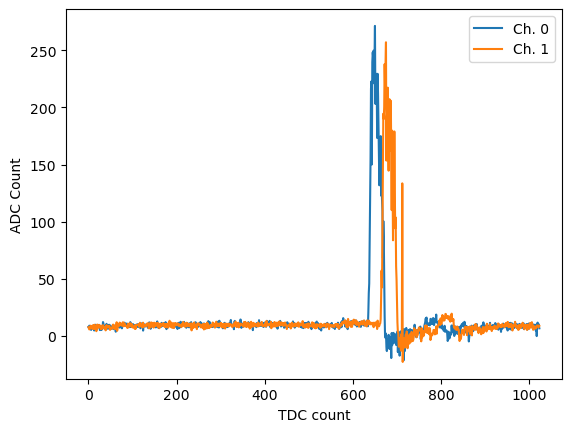

In [210]:
# event_num=np.random.randint(0, 299)
event_num = 77
print("Event number: {}".format(event_num))
event=acq[event_num]
corrected_event = corrector.run(event, correct_in_place=True)
time=corrected_event["time"]
adc=corrected_event["data"]
for ch in channels:
    plt.plot(time[ch],adc[ch],label=f"Ch. {ch}")
plt.legend()
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

## Timing analysis example

In [211]:
# event_num=76
event=acq[event_num]
corrected_event = corrector.run(event, correct_in_place=True)

ch=0
time=corrected_event["time"][ch]
adc=corrected_event["data"][ch]
loc=np.array([i for i in range(len(time))])
print(adc)
print(loc)

[ 8.   8.1  9.1 ... 10.7  8.8  6.8]
[   0    1    2 ... 1021 1022 1023]


Text(0, 0.5, 'ADC Count')

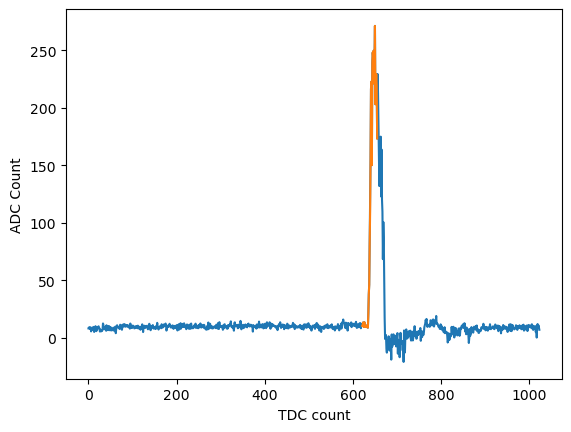

In [212]:
# extract the rising edge of the pulse
thre=200
n_back=20
n_forward=5
idx_thre=loc[time==time[adc>thre].min()][0]
idx_max=adc.argmax()+1
idx_start=idx_thre-n_back
idx_end=idx_max+n_forward
x,y=time[idx_start:idx_end],adc[idx_start:idx_end]
plt.plot(time,adc)
plt.plot(x,y)

plt.xlabel("TDC count")
plt.ylabel("ADC Count")

Text(0, 0.5, 'ADC Count')

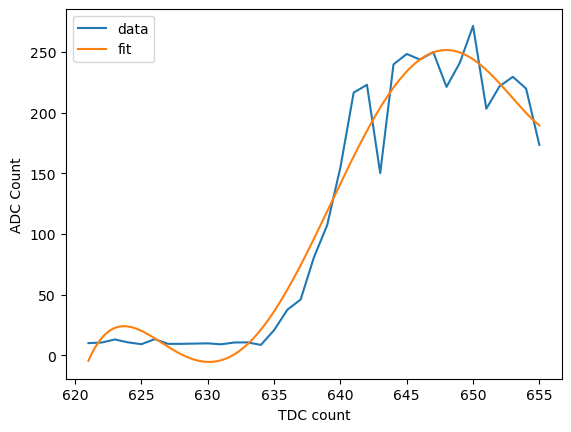

In [213]:
# Fit to the rising edge
fit=np.polyfit(x,y,5)
fitx=np.linspace(x.min(),x.max(),1000)
fity=np.poly1d(fit)(fitx)
plt.plot(x,y,label="data")
plt.plot(fitx,fity,label="fit")
plt.legend()
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

Text(0, 0.5, 'ADC Count')

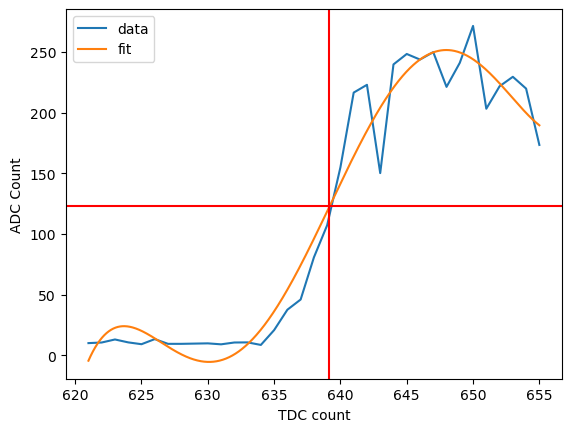

In [214]:
# calculate the half-peak timing
half_peak_adc=fity.min()+(fity.max()-fity.min())*0.5
half_peak_time=fitx[np.abs(fity-half_peak_adc).argmin()]
plt.plot(x,y,label="data")
plt.plot(fitx,fity,label="fit")
plt.axvline(half_peak_time,color="red")
plt.axhline(half_peak_adc,color="red")
plt.legend()
plt.xlabel("TDC count")
plt.ylabel("ADC Count") 

# run analysis

In [215]:
def fit(event_num,ch):
    try:
        event=acq[event_num]
        corrected_event = corrector.run(event, correct_in_place=True)
        
        time=corrected_event["time"][ch]
        adc=corrected_event["data"][ch]
        loc=np.array([i for i in range(len(time))])
    
        thre=200
        n_back=20
        n_forward=5
        idx_thre=loc[time==time[adc>thre].min()][0]
        idx_max=adc.argmax()+1
        idx_start=idx_thre-n_back
        idx_end=idx_max+n_forward
        x,y=time[idx_start:idx_end],adc[idx_start:idx_end]
        fit=np.polyfit(x,y,5)
        fitx=np.linspace(x.min(),x.max(),1000)
        fity=np.poly1d(fit)(fitx)
        half_peak_adc=fity.min()+(fity.max()-fity.min())*0.5
        half_peak_time=fitx[np.abs(fity-half_peak_adc).argmin()]
        return half_peak_time
    except:
        return 0

fit_results={ch:[] for ch in channels}

for ch in fit_results.keys():
    for event_num in range(len(acq)):
        fit_results[ch].append(fit(event_num,ch))

In [216]:
print(fit_results)

{0: [0, 643.1291291291292, 664.981981981982, 645.4144144144144, 658.3593593593594, 667.056056056056, 646.9399399399399, 668.8708708708708, 656.5545545545546, 641.027027027027, 661.073073073073, 646.8118118118118, 641.3753753753754, 657.2772772772773, 658.6046046046046, 664.2282282282282, 640.6626626626627, 663.2592592592592, 643.8468468468468, 656.8348348348349, 668.993993993994, 637.4154154154154, 658.1921921921922, 671.4154154154154, 639.1621621621622, 654.7387387387388, 664.1191191191191, 671.0780780780781, 666.8678678678679, 657.7387387387388, 639.4414414414414, 640.8378378378378, 654.8238238238238, 648.3243243243244, 667.2672672672672, 663.8398398398399, 664.1081081081081, 650.8208208208208, 654.1301301301302, 646.7087087087087, 669.8238238238238, 653.6666666666666, 647.002002002002, 666.8588588588589, 642.1531531531532, 651.5945945945946, 661.3513513513514, 657.942942942943, 644.6876876876877, 652.5945945945946, 660.3773773773773, 648.9489489489489, 648.3483483483484, 652.7137137

Ok, now we have an array with all the timestamps at which the half puse has been seen. Arry of all the half peaks. Now I want to compute the time difference between two consecutive pulses (later there is the comparison in between two channels, but let's start with one)

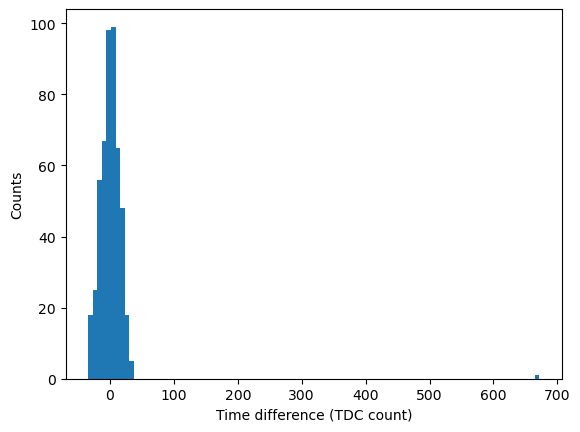

In [217]:
consec_time_diff = []
for i in range(len(acq)-1):
    consec_time_diff.append(fit_results[ch][i+1]-fit_results[ch][i])
plt.hist(consec_time_diff,bins=100)
plt.xlabel("Time difference (TDC count)")
plt.ylabel("Counts")
plt.show()

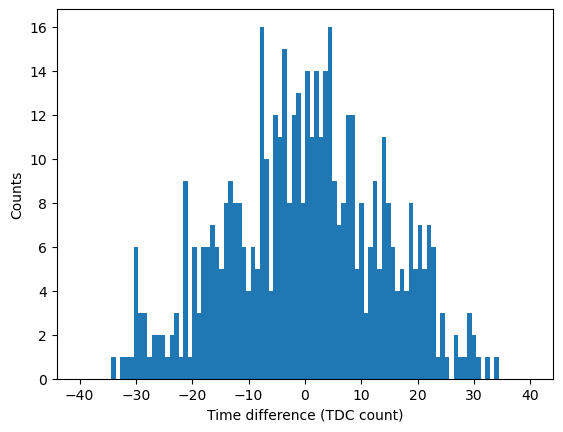

[671.8568568568569, 22.199199199199143, -21.35935935935936, 13.549549549549624, 10.267267267267243, -20.998998998999014, 22.198198198198156, -13.49749749749742, -16.43143143143152, 21.732732732732757, -13.237237237237196, -7.700700700700736, 16.412412412412436, 1.096096096096062, 5.610610610610593, -22.48848848848843, 22.709709709709728, -19.79979979979987, 11.256256256256279, 14.14214214214212, -31.751751751751726, 19.20120120120123, 13.885885885885841, -31.118118118118105, 14.325325325325366, 11.519519519519463, 5.946946946946923, -4.428428428428333, -8.96496496496502, -18.30730730730727, 1.314314314314288, 14.467467467467486, -6.767767767767737, 18.95095095095087, -3.740740740740762, 0.1401401401401472, -12.905905905905911, 2.3243243243243796, -7.353353353353327, 24.582582582582518, -16.797797797797784, -6.0820820820820245, 19.852852852852834, -26.193193193193224, 10.235235235235223, 8.822822822822786, -2.770770770770696, -12.186186186186205, 7.755755755755786, 7.390390390390394, -1

In [218]:
# Let's set a range
consec_range = (-40,40)
plt.hist(consec_time_diff,bins=100,range=consec_range)
plt.xlabel("Time difference (TDC count)")
plt.ylabel("Counts")
plt.show()
print(consec_time_diff)

In [219]:
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit import Minuit
def gaussian(x,mu,sigma,N):
    return N, N/(np.sqrt( 2*np.pi )*sigma)*np.exp( -(x-mu)**2/(2*sigma**2) )
consec_time_diff = np.array(consec_time_diff)
mask = (consec_time_diff > consec_range[0]) & (consec_time_diff < consec_range[1])
consec_time_diff = consec_time_diff[mask]
    
lh=ExtendedUnbinnedNLL(consec_time_diff, gaussian)

m = Minuit(lh,mu=0,sigma=10,N=len(consec_time_diff))
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1163                      │              Nfcn = 59               │
│ EDM = 3.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │    0.0    │    0.6    │            │            │         │         │       │
│ 1 │ sigma │   13.8    │    0.4    │            │            │         │         │       │
│ 2 │ N     │    499    │    22     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │    mu sigma     N │
├───────┼───────────────────┤
│    mu │ 0.384  0.00  -0.0 │
│ sigma │  0.00 0.192 -0.00 │
│     N │  -0.0 -0.00   499 │
└───────┴───────────────────┘

### Now we look at the time difference between two channels in order to see the time resolution (split test pulse)

Text(0.5, 0, 'TDC count')

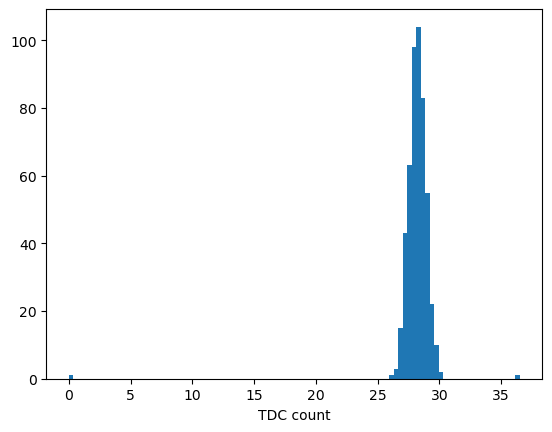

In [220]:
timing_difference=np.abs(np.array(fit_results[0])-np.array(fit_results[1]))
plt.hist(timing_difference,bins=100)
plt.xlabel("TDC count")

Here in some data samples there are empty events that compromise the quality of the analysis.
We just do not consider them in the subsequent analysis.

Text(0.5, 0, 'TDC count')

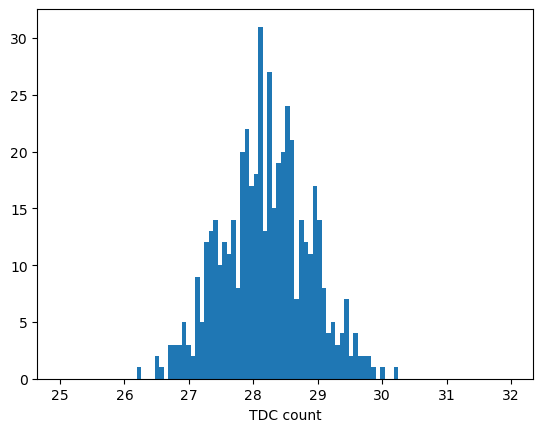

In [221]:
hrange=(25,32)

plt.hist(timing_difference,bins=100,range=hrange)
plt.xlabel("TDC count")

In [222]:
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit import Minuit
def gaussian(x,mu,sigma,N):
    return N, N/(np.sqrt( 2*np.pi )*sigma)*np.exp( -(x-mu)**2/(2*sigma**2) )
timing_difference=timing_difference[timing_difference>hrange[0]]
timing_difference=timing_difference[timing_difference<hrange[1]]
    
lh=ExtendedUnbinnedNLL(timing_difference,gaussian)

m = Minuit(lh,mu=28,sigma=1,N=len(timing_difference))
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4176                      │              Nfcn = 154              │
│ EDM = 8.04e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   28.20   │   0.03    │            │            │         │         │       │
│ 1 │ sigma │   0.676   │   0.021   │            │            │         │         │       │
│ 2 │ N     │    499    │    22     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │       mu    sigma        N │
├───────┼────────────────────────────┤
│    mu │ 0.000917        0       -0 │
│ sigma │        0 0.000458       -0 │
│     N │       -0       -0      499 │
└───────┴────────────────────────────┘

# PEDESTAL ANALYSIS

In [223]:
cell_ped = np.zeros((len(acq), 128, 5))

for ev in range(len(acq)):
    event=acq[ev]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"][0]
    adc=corrected_event["data"][0]
    mask=(time<640)
    cell_ped[ev] = adc[mask].reshape(5, 128).T

print(cell_ped.shape)

(501, 128, 5)


In [224]:
final_cell_corr = np.mean(cell_ped, axis=(0, 2))
print(final_cell_corr)

[10.85013972 10.58666667 10.65772455 10.72546906 10.61720559 10.73189621
 10.36522954 10.46954092 11.23285429 10.6497006  10.49736527 11.40606786
 10.57864271 10.40786427 10.04610778 11.15061876 10.85325349 11.09764471
 10.43161677 10.5500998  10.13305389 11.23265469 10.61017964 10.12682635
 11.13201597 11.55684631 10.09373253 10.92151697 11.06590818 10.27976048
 11.57213573 10.39740519 10.95389222 10.9994012  10.6647505  10.59097804
 10.68083832 10.61001996 10.99600798 10.79972056 10.50850299 11.46650699
 11.32670659  9.76027944 10.43824351 11.28251497 10.95916168 10.68862275
 10.30810379 10.65481038 10.83904192 10.37437126 10.59932136 10.61177645
 10.40427146 10.92678643 10.62550898 10.29944112 10.50227545 10.19201597
 10.67053892 10.34051896 10.68015968 10.17888224 10.51157685 10.22087824
 10.95840319 10.19876248 10.23417166 10.44151697 11.66622754 10.06846307
 10.65812375 10.44287425 10.48295409 10.43093812 10.87033932 11.05249501
 11.1451497  10.78391218 10.8011976  11.13656687 10

Text(0, 0.5, 'ADC Count')

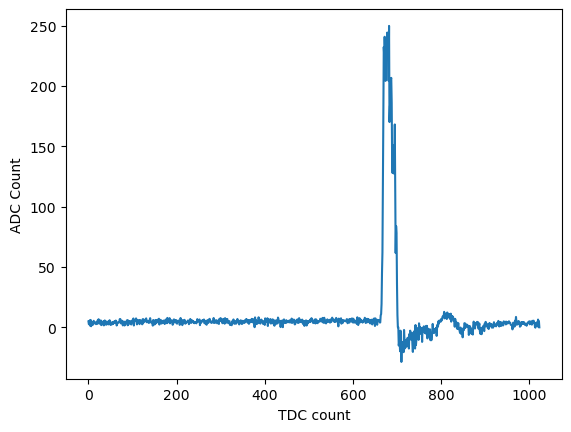

In [225]:
plt.plot(time, adc, label="Ch. 0")
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

Text(0, 0.5, 'ADC Count')

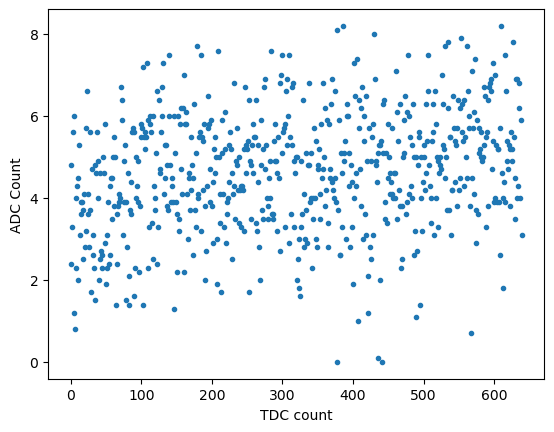

In [226]:
plt.plot(time[mask],adc[mask],'.')
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

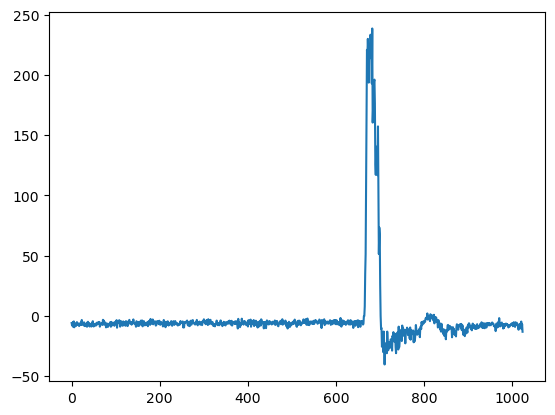

In [227]:
for i in range(len(time)//128):
    for j in range(128):
        adc[128*i + j] = adc[128*i + j] - final_cell_corr[j]
plt.plot(time, adc, label="Ch. 0")

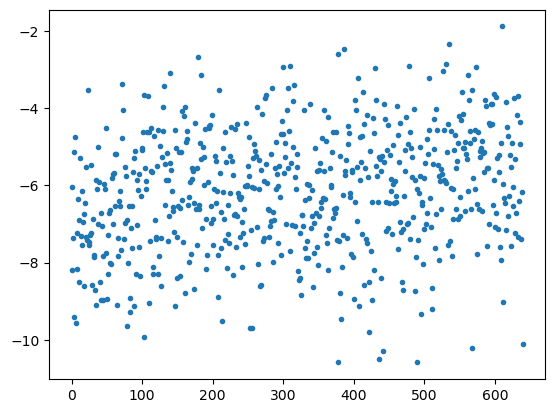

In [228]:
plt.plot(time[mask],adc[mask],'.')